<a href="https://colab.research.google.com/github/ProductPriceTrackerOrg/data-science/blob/main/notebooks/price-forecasing/03_model_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## Cell 1: Install required packages


In [1]:
!pip install lightgbm
!pip install tensorflow
!pip install scipy
!git clone "https://github.com/ProductPriceTrackerOrg/data-science.git"

Cloning into 'data-science'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 99 (delta 20), reused 73 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (99/99), 5.89 MiB | 6.89 MiB/s, done.
Resolving deltas: 100% (20/20), done.




## Cell 2: Enhanced imports


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Enhanced imports
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import savgol_filter



## Cell 3: Load data (keep your existing data loading)


In [3]:
# ...existing code...
camera = pd.read_csv('/content/data-science/data/raw/price-forecasting/category/cameras.csv')
laptop = pd.read_csv('/content/data-science/data/raw/price-forecasting/category/laptops.csv')
mobile = pd.read_csv('/content/data-science/data/raw/price-forecasting/category/mobile-phones.csv')
network_components = pd.read_csv('/content/data-science/data/raw/price-forecasting/category/network-components.csv')
perpherials = pd.read_csv('/content/data-science/data/raw/price-forecasting/category/perpherals.csv')
smart_watches = pd.read_csv('/content/data-science/data/raw/price-forecasting/category/smart-watches.csv')
storage = pd.read_csv('/content/data-science/data/raw/price-forecasting/category/storage.csv')
tablets = pd.read_csv('/content/data-science/data/raw/price-forecasting/category/tablets.csv')
television = pd.read_csv('/content/data-science/data/raw/price-forecasting/category/television.csv')



## Cell 4: Process individual datasets


In [4]:
# Function to process each dataset
def process_dataset(df, category_name):
    df['date'] = pd.to_datetime(df['date'])
    df['category'] = category_name
    df['price'] = df['price'] * 3.4
    print(f"{category_name} - Null values: {df.isnull().sum().sum()}")
    print(f"{category_name} - Shape: {df.shape}")
    return df

# Process all datasets
camera = process_dataset(camera, 'camera')
laptop = process_dataset(laptop, 'laptop')
mobile = process_dataset(mobile, 'mobile')
network_components = process_dataset(network_components, 'network-components')
perpherials = process_dataset(perpherials, 'perpherials')
smart_watches = process_dataset(smart_watches, 'smart-watches')
storage = process_dataset(storage, 'storage')
tablets = process_dataset(tablets, 'tablets')
television = process_dataset(television, 'television')

# Combine all datasets
all_products = pd.concat([camera, laptop, mobile, network_components, perpherials,
                         smart_watches, storage, tablets, television], ignore_index=True)

print(f"Combined dataset shape: {all_products.shape}")
all_products.head()

camera - Null values: 0
camera - Shape: (15090, 5)
laptop - Null values: 0
laptop - Shape: (118708, 5)
mobile - Null values: 0
mobile - Shape: (146876, 5)
network-components - Null values: 0
network-components - Shape: (13078, 5)
perpherials - Null values: 0
perpherials - Shape: (73438, 5)
smart-watches - Null values: 0
smart-watches - Shape: (161966, 5)
storage - Null values: 0
storage - Shape: (267596, 5)
tablets - Null values: 0
tablets - Shape: (60360, 5)
television - Null values: 0
television - Shape: (121726, 5)
Combined dataset shape: (978838, 5)


,title,brand,date,price,category
0,Canon R100 Mirrorless Camera RF-S 18-45mm f/4....,CANON,2022-11-01,10196.6,camera
1,Canon R100 Mirrorless Camera RF-S 18-45mm f/4....,CANON,2022-11-02,9370.4,camera
2,Canon R100 Mirrorless Camera RF-S 18-45mm f/4....,CANON,2022-11-03,10087.8,camera
3,Canon R100 Mirrorless Camera RF-S 18-45mm f/4....,CANON,2022-11-04,9214.0,camera
4,Canon R100 Mirrorless Camera RF-S 18-45mm f/4....,CANON,2022-11-05,10614.8,camera




## Cell 5: Enhanced data preprocessing function


In [5]:
def load_and_preprocess_data(df):
    """Enhanced data preprocessing"""
    print("Loading and preprocessing data...")

    # Convert date column
    df['date'] = pd.to_datetime(df['date'])

    # Remove outliers using IQR method
    Q1 = df['price'].quantile(0.25)
    Q3 = df['price'].quantile(0.75)
    IQR = Q3 - Q1
    original_size = len(df)
    df = df[(df['price'] >= Q1 - 1.5 * IQR) & (df['price'] <= Q3 + 1.5 * IQR)]
    print(f"Removed {original_size - len(df)} outliers")

    # Sort by product and date
    df = df.sort_values(['title', 'brand', 'date']).reset_index(drop=True)

    # Create unique product ID
    df['product_id'] = df.groupby(['title', 'brand']).ngroup()

    # Add price smoothing
    print("Applying price smoothing...")
    for product_id in df['product_id'].unique():
        mask = df['product_id'] == product_id
        prices = df.loc[mask, 'price'].values
        if len(prices) >= 5:
            window_length = min(5, len(prices) if len(prices) % 2 == 1 else len(prices) - 1)
            if window_length >= 3:
                smoothed = savgol_filter(prices, window_length, 2)
                df.loc[mask, 'price_smoothed'] = smoothed
            else:
                df.loc[mask, 'price_smoothed'] = prices
        else:
            df.loc[mask, 'price_smoothed'] = prices

    return df



## Cell 6: Enhanced feature engineering function


In [6]:
def create_advanced_features(df):
    """Enhanced feature engineering"""
    print("Creating advanced features...")

    df_features = df.copy()

    # Enhanced temporal features
    df_features['year'] = df_features['date'].dt.year
    df_features['month'] = df_features['date'].dt.month
    df_features['day'] = df_features['date'].dt.day
    df_features['day_of_week'] = df_features['date'].dt.dayofweek
    df_features['quarter'] = df_features['date'].dt.quarter
    df_features['week_of_year'] = df_features['date'].dt.isocalendar().week
    df_features['is_weekend'] = df_features['day_of_week'].isin([5, 6]).astype(int)
    df_features['is_month_start'] = df_features['date'].dt.is_month_start.astype(int)
    df_features['is_month_end'] = df_features['date'].dt.is_month_end.astype(int)

    # Seasonal and holiday features
    df_features['is_holiday_season'] = df_features['month'].isin([11, 12]).astype(int)
    df_features['is_new_year'] = df_features['month'].eq(1).astype(int)
    df_features['is_mid_year'] = df_features['month'].isin([6, 7]).astype(int)

    # Cyclical encoding for temporal features
    df_features['month_sin'] = np.sin(2 * np.pi * df_features['month'] / 12)
    df_features['month_cos'] = np.cos(2 * np.pi * df_features['month'] / 12)
    df_features['day_sin'] = np.sin(2 * np.pi * df_features['day'] / 31)
    df_features['day_cos'] = np.cos(2 * np.pi * df_features['day'] / 31)

    return df_features



## Cell 7: Product-specific feature engineering


In [7]:
def create_product_features(df_features):
    """Create product-specific features"""
    print("Creating product-specific features...")

    product_features = []
    total_products = df_features['product_id'].nunique()

    for idx, product_id in enumerate(df_features['product_id'].unique()):
        if idx % 100 == 0:
            print(f"Processing product {idx}/{total_products}")

        product_data = df_features[df_features['product_id'] == product_id].copy()
        product_data = product_data.sort_values('date')

        # Enhanced price lags
        for lag in [1, 2, 3, 7, 14, 30]:
            product_data[f'price_lag_{lag}'] = product_data['price'].shift(lag)

        # Price changes and momentum
        for window in [1, 3, 7, 14, 30]:
            product_data[f'price_change_{window}d'] = product_data['price'].pct_change(window)
            product_data[f'price_momentum_{window}d'] = product_data['price'] / product_data['price'].shift(window) - 1

        # Enhanced rolling statistics
        for window in [3, 7, 14, 30]:
            product_data[f'price_rolling_mean_{window}'] = product_data['price'].rolling(window, min_periods=1).mean()
            product_data[f'price_rolling_std_{window}'] = product_data['price'].rolling(window, min_periods=1).std()
            product_data[f'price_rolling_min_{window}'] = product_data['price'].rolling(window, min_periods=1).min()
            product_data[f'price_rolling_max_{window}'] = product_data['price'].rolling(window, min_periods=1).max()

        # Price volatility and stability
        for window in [7, 14, 30]:
            product_data[f'price_volatility_{window}'] = product_data[f'price_change_1d'].rolling(window, min_periods=1).std()

        # Trend analysis
        product_data['days_since_start'] = (product_data['date'] - product_data['date'].min()).dt.days

        # Price position features
        for window in [7, 14, 30]:
            product_data[f'price_percentile_{window}'] = product_data['price'].rolling(window, min_periods=1).rank(pct=True)

        product_features.append(product_data)

    return pd.concat(product_features, ignore_index=True)



## Cell 8: Market-level features


In [8]:
def create_market_features(df_features):
    """Create market-level features"""
    print("Creating market-level features...")

    # Category statistics by date
    category_stats = df_features.groupby(['category', 'date'])['price'].agg([
        'mean', 'std', 'min', 'max', 'count', 'median'
    ]).reset_index()
    category_stats.columns = ['category', 'date'] + [f'category_price_{col}' for col in category_stats.columns[2:]]
    df_features = df_features.merge(category_stats, on=['category', 'date'], how='left')

    # Brand statistics by date
    brand_stats = df_features.groupby(['brand', 'date'])['price'].agg([
        'mean', 'std', 'count'
    ]).reset_index()
    brand_stats.columns = ['brand', 'date'] + [f'brand_price_{col}' for col in brand_stats.columns[2:]]
    df_features = df_features.merge(brand_stats, on=['brand', 'date'], how='left')

    # Relative price features
    df_features['price_vs_category_mean'] = df_features['price'] / df_features['category_price_mean']
    df_features['price_vs_category_median'] = df_features['price'] / df_features['category_price_median']
    df_features['price_vs_brand_mean'] = df_features['price'] / df_features['brand_price_mean']

    # Market competition features
    df_features['category_competition'] = df_features['category_price_count']
    df_features['brand_market_share'] = df_features['brand_price_count'] / df_features['category_price_count']

    # Fill NaN values with forward fill, backward fill, then 0
    df_features = df_features.fillna(method='ffill').fillna(method='bfill').fillna(0)

    # Replace infinite values
    df_features = df_features.replace([np.inf, -np.inf], 0)

    return df_features



## Cell 9: Create target variables


In [9]:
def create_target_variables(df):
    """Create target variables with additional preprocessing"""
    print("Creating target variables...")

    targets = []

    for product_id in df['product_id'].unique():
        product_data = df[df['product_id'] == product_id].copy().sort_values('date')

        # Create 7-day ahead targets
        for i in range(1, 8):
            product_data[f'price_target_{i}d'] = product_data['price'].shift(-i)

        targets.append(product_data)

    df_with_targets = pd.concat(targets, ignore_index=True)

    # Remove rows where we don't have all 7-day targets
    target_cols = [f'price_target_{i}d' for i in range(1, 8)]
    df_with_targets = df_with_targets.dropna(subset=target_cols)

    return df_with_targets



## Cell 10: Data preparation


In [10]:
def prepare_model_data(df):
    """Enhanced data preparation"""
    print("Preparing model data...")

    # Encode categorical variables
    le_brand = LabelEncoder()
    le_category = LabelEncoder()

    df['brand_encoded'] = le_brand.fit_transform(df['brand'])
    df['category_encoded'] = le_category.fit_transform(df['category'])

    # Select features (exclude target columns and non-feature columns)
    exclude_cols = ['title', 'brand', 'category', 'date', 'price', 'price_smoothed'] + \
                  [f'price_target_{i}d' for i in range(1, 8)]

    feature_cols = [col for col in df.columns if col not in exclude_cols]
    target_cols = [f'price_target_{i}d' for i in range(1, 8)]

    print(f"Number of features: {len(feature_cols)}")

    # Prepare features and targets
    X = df[feature_cols].fillna(0)
    y = df[target_cols].fillna(0)

    # Use RobustScaler for better outlier handling
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)

    return X_scaled, y.values, df, scaler, le_brand, le_category, feature_cols



## Cell 11: Execute preprocessing pipeline


In [11]:
# Execute the preprocessing pipeline
print("Starting preprocessing pipeline...")

# Step 1: Basic preprocessing
df = load_and_preprocess_data(all_products)

# Step 2: Create temporal features
df = create_advanced_features(df)

# Step 3: Create product-specific features
df = create_product_features(df)

# Step 4: Create market-level features
df = create_market_features(df)

# Step 5: Create target variables
df = create_target_variables(df)

print(f"Final dataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

Starting preprocessing pipeline...
Loading and preprocessing data...
Removed 5889 outliers
Applying price smoothing...
Creating advanced features...
Creating product-specific features...
Processing product 0/869
Processing product 100/869
Processing product 200/869
Processing product 300/869
Processing product 400/869
Processing product 500/869
Processing product 600/869
Processing product 700/869
Processing product 800/869
Creating market-level features...
Creating target variables...
Final dataset shape: (966866, 83)
Date range: 2022-11-01 00:00:00 to 2025-08-02 00:00:00




## Cell 12: Prepare data for modeling


In [12]:
# Prepare model data
X, y, df_processed, scaler, le_brand, le_category, feature_cols = prepare_model_data(df)

# Time-based split (use more recent data for validation)
split_date = df_processed['date'].quantile(0.85)
train_mask = df_processed['date'] <= split_date

X_train, X_val = X[train_mask], X[~train_mask]
y_train, y_val = y[train_mask], y[~train_mask]

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Feature dimensions: {X_train.shape[1]}")

Preparing model data...
Number of features: 72
Training samples: 822024
Validation samples: 144842
Feature dimensions: 72




## Cell 13: Build LightGBM models


In [13]:
def build_lightgbm_models(X_train, y_train, X_val, y_val):
    """Build LightGBM models"""
    print("Building LightGBM models...")

    lgb_models = []
    for i in range(7):
        print(f"Training LightGBM for day {i+1}...")
        model = lgb.LGBMRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=8,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            verbose=-1
        )

        model.fit(
            X_train, y_train[:, i],
            eval_set=[(X_val, y_val[:, i])],
            callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
        )
        lgb_models.append(model)

    return lgb_models

# Train LightGBM models
lgb_models = build_lightgbm_models(X_train, y_train, X_val, y_val)

Building LightGBM models...
Training LightGBM for day 1...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[146]	valid_0's l2: 1.73787e+07
Training LightGBM for day 2...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[127]	valid_0's l2: 1.73798e+07
Training LightGBM for day 3...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[146]	valid_0's l2: 1.73827e+07
Training LightGBM for day 4...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[186]	valid_0's l2: 1.74287e+07
Training LightGBM for day 5...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[186]	valid_0's l2: 1.73655e+07
Training LightGBM for day 6...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[163]	valid_0's l2: 1.74045e+07
Training LightGBM 



## Cell 14: Build XGBoost models


In [15]:
def build_xgboost_models(X_train, y_train, X_val, y_val):
    """Build XGBoost models"""
    print("Building XGBoost models...")

    xgb_models = []
    for i in range(7):
        print(f"Training XGBoost for day {i+1}...")
        model = xgb.XGBRegressor(
            n_estimators=500,
            max_depth=8,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            early_stopping_rounds=50,
            verbosity=0
        )

        model.fit(
            X_train, y_train[:, i],
            eval_set=[(X_val, y_val[:, i])],
            verbose=False
        )
        xgb_models.append(model)

    return xgb_models

# Train XGBoost models
xgb_models = build_xgboost_models(X_train, y_train, X_val, y_val)

Building XGBoost models...
Training XGBoost for day 1...
Training XGBoost for day 2...
Training XGBoost for day 3...
Training XGBoost for day 4...
Training XGBoost for day 5...
Training XGBoost for day 6...
Training XGBoost for day 7...




## Cell 15: Build Neural Network model


In [16]:
def build_neural_network(X_train, y_train, X_val, y_val):
    """Build enhanced neural network model"""
    print("Building Neural Network model...")

    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(7)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='huber',
        metrics=['mae']
    )

    callbacks = [
        EarlyStopping(patience=20, restore_best_weights=True),
        ReduceLROnPlateau(patience=10, factor=0.5)
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=256,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

# Train Neural Network
nn_model, history = build_neural_network(X_train, y_train, X_val, y_val)

Building Neural Network model...
Epoch 1/100
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - loss: 19674.0762 - mae: 19674.5898 - val_loss: 2279.0383 - val_mae: 2279.5383 - learning_rate: 0.0010
Epoch 2/100
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 5220.1987 - mae: 5220.6948 - val_loss: 2428.3550 - val_mae: 2428.8550 - learning_rate: 0.0010
Epoch 3/100
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - loss: 5021.9570 - mae: 5022.4590 - val_loss: 2610.8916 - val_mae: 2611.3916 - learning_rate: 0.0010
Epoch 4/100
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 43s 11ms/step - loss: 4855.2007 - mae: 4855.7007 - val_loss: 3214.9851 - val_mae: 3215.4851 - learning_rate: 0.0010
Epoch 5/100
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - loss: 4655.4253 - mae: 4655.9253 - val_loss: 4886.7441 - val_mae: 4887.2446 - learning_rate: 0.0010
Epoch 6/100
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - loss: 4278.4468 - mae: 4278.9468 - val_loss: 6429.8340 - val_mae: 6430.3340 - learning_rate: 0.0010
Epoch 7/100



## Cell 16: Build ensemble predictions


In [17]:
def predict_ensemble(X, lgb_models, xgb_models, nn_model):
    """Make ensemble predictions with dynamic weighting"""
    print("Making ensemble predictions...")

    # Get predictions from each model
    lgb_preds = np.array([model.predict(X) for model in lgb_models]).T
    xgb_preds = np.array([model.predict(X) for model in xgb_models]).T
    nn_preds = nn_model.predict(X, verbose=0)

    # Dynamic ensemble with different weights for different prediction horizons
    weights = {
        'lightgbm': [0.4, 0.35, 0.35, 0.3, 0.3, 0.25, 0.25],
        'xgboost': [0.35, 0.35, 0.3, 0.3, 0.25, 0.25, 0.2],
        'neural_network': [0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]
    }

    ensemble_pred = np.zeros_like(lgb_preds)
    for i in range(7):
        ensemble_pred[:, i] = (
            weights['lightgbm'][i] * lgb_preds[:, i] +
            weights['xgboost'][i] * xgb_preds[:, i] +
            weights['neural_network'][i] * nn_preds[:, i]
        )

    return ensemble_pred, {'lightgbm': lgb_preds, 'xgboost': xgb_preds, 'neural_network': nn_preds}

# Make ensemble predictions
ensemble_pred, individual_preds = predict_ensemble(X_val, lgb_models, xgb_models, nn_model)

Making ensemble predictions...




## Cell 17: Enhanced evaluation


In [18]:
def evaluate_model_enhanced(y_true, y_pred, model_name="Ensemble"):
    """Enhanced model evaluation"""
    print(f"\n--- {model_name} Model Performance Evaluation ---")

    metrics = {}
    for i in range(7):
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
        r2 = r2_score(y_true[:, i], y_pred[:, i])

        # Calculate MAPE manually to handle division by zero
        mape = np.mean(np.abs((y_true[:, i] - y_pred[:, i]) / np.maximum(y_true[:, i], 1e-8))) * 100

        metrics[f'day_{i+1}'] = {
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'MAPE': mape
        }

        print(f"\nMetrics for Day {i+1}:")
        print(f"  MAE:  {mae:.2f}")
        print(f"  RMSE: {rmse:.2f}")
        print(f"  R²:   {r2:.4f}")
        print(f"  MAPE: {mape:.2f}%")

    # Overall metrics
    overall_mae = mean_absolute_error(y_true, y_pred)
    overall_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    overall_r2 = r2_score(y_true, y_pred)

    print(f"\n--- Overall Performance ---")
    print(f"  Overall MAE:  {overall_mae:.2f}")
    print(f"  Overall RMSE: {overall_rmse:.2f}")
    print(f"  Overall R²:   {overall_r2:.4f}")

    return metrics

# Evaluate ensemble model
ensemble_metrics = evaluate_model_enhanced(y_val, ensemble_pred, "Ensemble")

# Evaluate individual models
lgb_metrics = evaluate_model_enhanced(y_val, individual_preds['lightgbm'], "LightGBM")
xgb_metrics = evaluate_model_enhanced(y_val, individual_preds['xgboost'], "XGBoost")
nn_metrics = evaluate_model_enhanced(y_val, individual_preds['neural_network'], "Neural Network")


--- Ensemble Model Performance Evaluation ---

Metrics for Day 1:
  MAE:  2219.09
  RMSE: 4169.71
  R²:   0.9948
  MAPE: 4.63%

Metrics for Day 2:
  MAE:  2226.32
  RMSE: 4175.00
  R²:   0.9948
  MAPE: 4.68%

Metrics for Day 3:
  MAE:  2232.61
  RMSE: 4176.98
  R²:   0.9948
  MAPE: 4.72%

Metrics for Day 4:
  MAE:  2235.67
  RMSE: 4180.85
  R²:   0.9948
  MAPE: 4.74%

Metrics for Day 5:
  MAE:  2240.74
  RMSE: 4185.40
  R²:   0.9947
  MAPE: 4.77%

Metrics for Day 6:
  MAE:  2244.78
  RMSE: 4190.37
  R²:   0.9947
  MAPE: 4.80%

Metrics for Day 7:
  MAE:  2252.17
  RMSE: 4201.93
  R²:   0.9947
  MAPE: 4.82%

--- Overall Performance ---
  Overall MAE:  2235.91
  Overall RMSE: 4182.90
  Overall R²:   0.9947

--- LightGBM Model Performance Evaluation ---

Metrics for Day 1:
  MAE:  2219.41
  RMSE: 4168.78
  R²:   0.9948
  MAPE: 4.64%

Metrics for Day 2:
  MAE:  2226.79
  RMSE: 4168.90
  R²:   0.9948
  MAPE: 4.72%

Metrics for Day 3:
  MAE:  2228.46
  RMSE: 4169.25
  R²:   0.9948
  MAPE: 4.



## Cell 18: Visualization


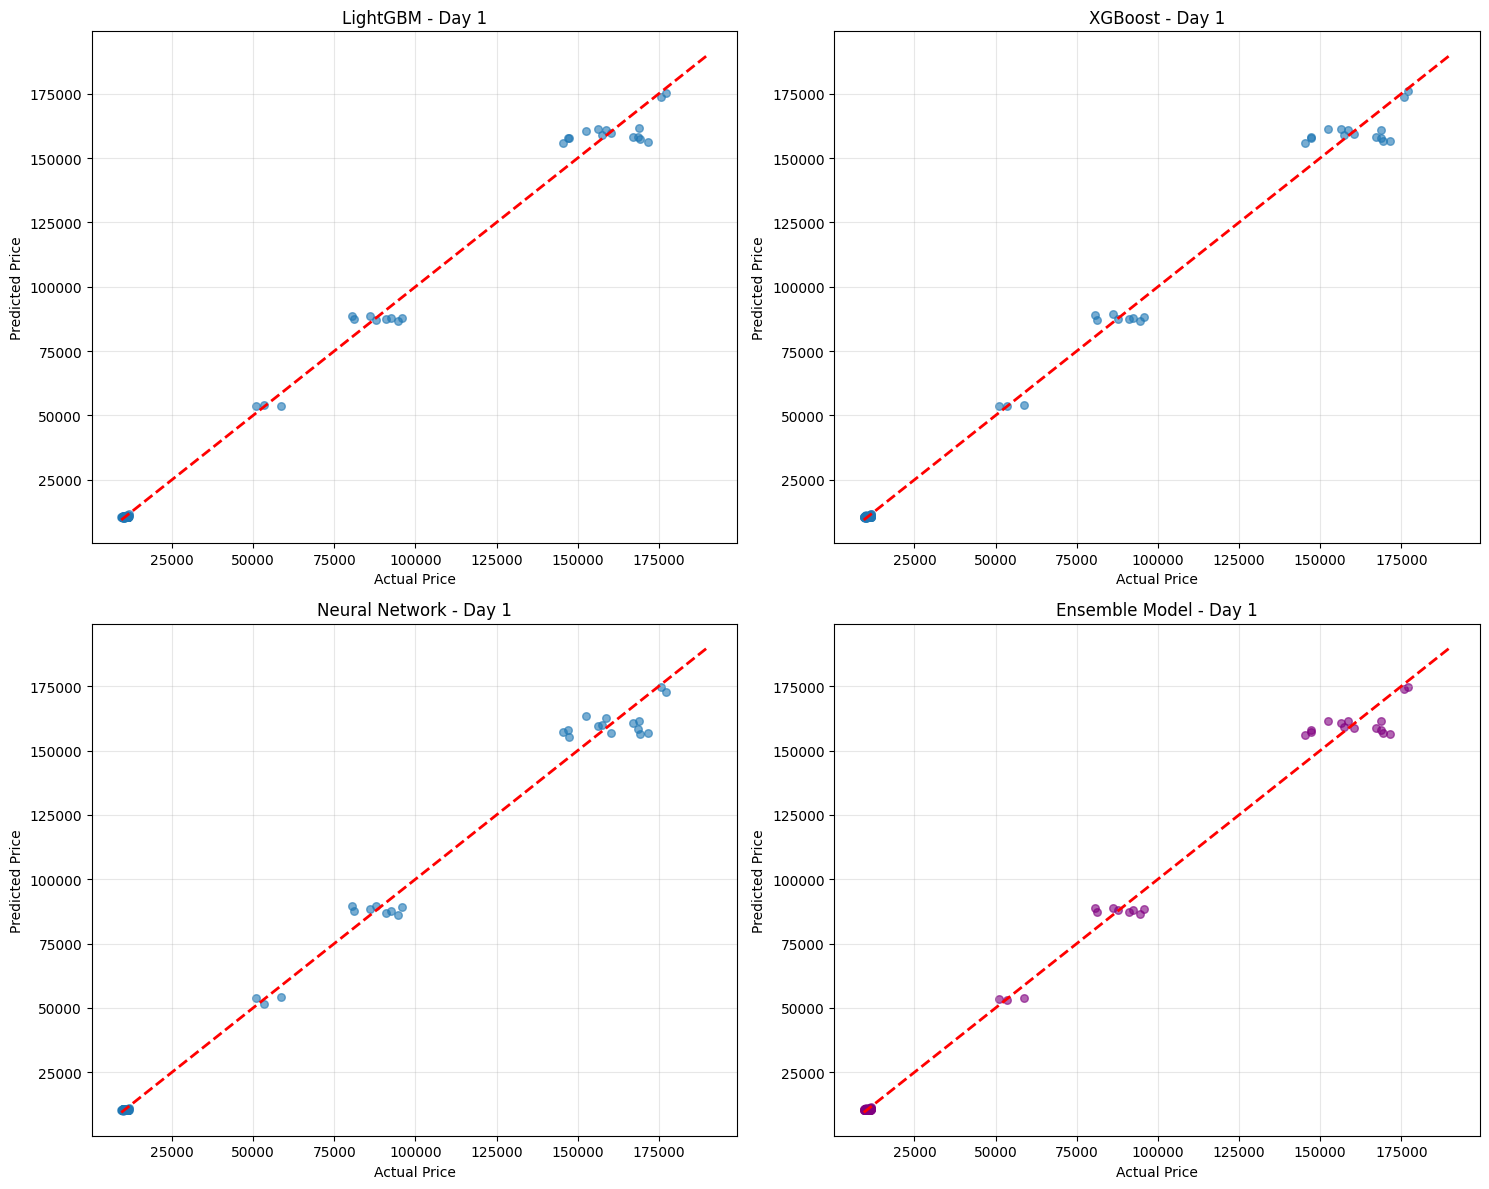

In [23]:
def plot_model_comparison(y_true, ensemble_pred, individual_preds, day_to_plot=0, num_samples=100):
    """Plot model comparison"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    models = ['lightgbm', 'xgboost', 'neural_network']
    model_names = ['LightGBM', 'XGBoost', 'Neural Network']

    sample_indices = np.random.choice(len(y_true), min(num_samples, len(y_true)), replace=False)

    # Individual models
    for i, (model_key, model_name) in enumerate(zip(models, model_names)):
        ax = axes[i]
        ax.scatter(y_true[sample_indices, day_to_plot],
                  individual_preds[model_key][sample_indices, day_to_plot],
                  alpha=0.6, s=30)
        ax.plot([y_true[:, day_to_plot].min(), y_true[:, day_to_plot].max()],
               [y_true[:, day_to_plot].min(), y_true[:, day_to_plot].max()], 'r--', lw=2)
        ax.set_xlabel('Actual Price')
        ax.set_ylabel('Predicted Price')
        ax.set_title(f'{model_name} - Day {day_to_plot + 1}')
        ax.grid(True, alpha=0.3)

    # Ensemble model
    ax = axes[3]
    ax.scatter(y_true[sample_indices, day_to_plot],
              ensemble_pred[sample_indices, day_to_plot],
              alpha=0.6, s=30, color='purple')
    ax.plot([y_true[:, day_to_plot].min(), y_true[:, day_to_plot].max()],
           [y_true[:, day_to_plot].min(), y_true[:, day_to_plot].max()], 'r--', lw=2)
    ax.set_xlabel('Actual Price')
    ax.set_ylabel('Predicted Price')
    ax.set_title(f'Ensemble Model - Day {day_to_plot + 1}')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot comparison for Day 1
plot_model_comparison(y_val, ensemble_pred, individual_preds, day_to_plot=0, num_samples=100)



## Cell 19: Feature importance analysis


Analyzing feature importance...


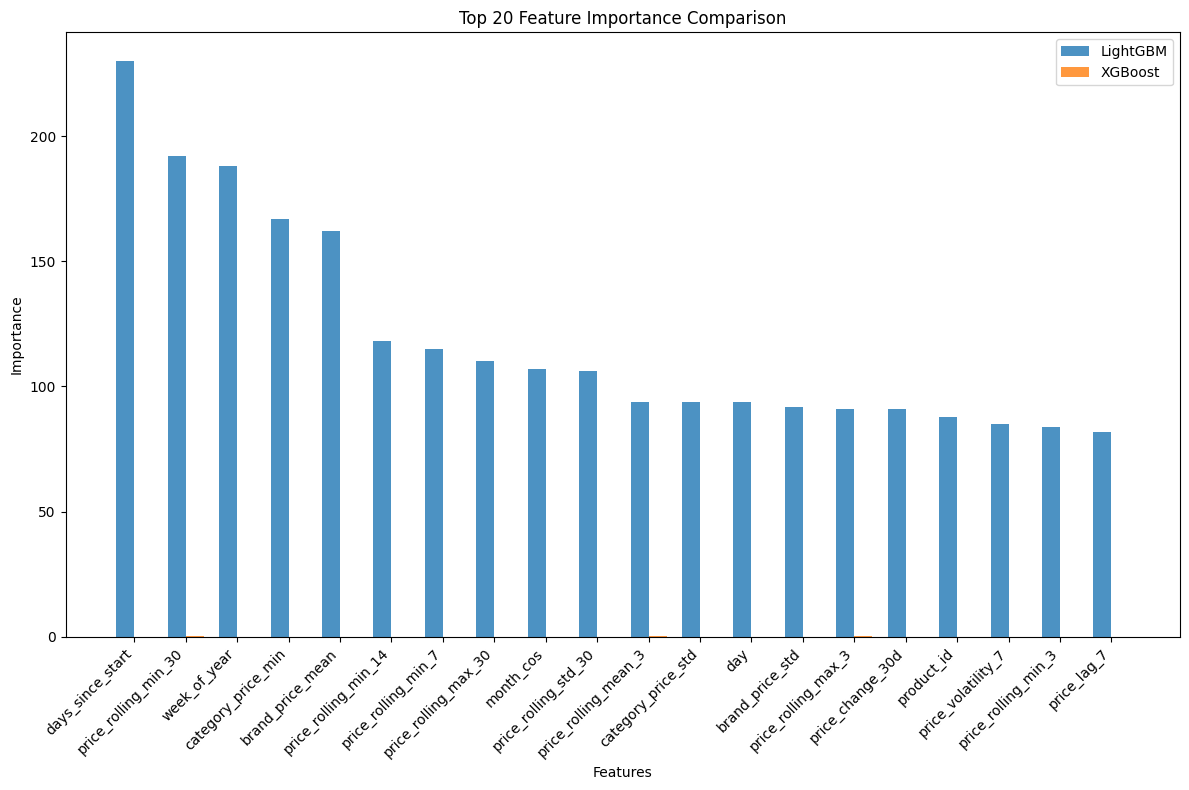


Top 10 Most Important Features:
                 feature  avg_importance
52      days_since_start      115.000005
47  price_rolling_min_30       96.197958
6           week_of_year       94.000015
58    category_price_min       83.500017
62      brand_price_mean       81.000166
43  price_rolling_min_14       59.026891
39   price_rolling_min_7       57.532141
48  price_rolling_max_30       55.000161
14             month_cos       53.500154
46  price_rolling_std_30       53.000007


In [20]:
def analyze_feature_importance(lgb_models, xgb_models, feature_cols):
    """Analyze feature importance"""
    print("Analyzing feature importance...")

    # Get feature importance from LightGBM (Day 1 model)
    lgb_importance = lgb_models[0].feature_importances_

    # Get feature importance from XGBoost (Day 1 model)
    xgb_importance = xgb_models[0].feature_importances_

    # Create feature importance dataframe
    importance_df = pd.DataFrame({
        'feature': feature_cols,
        'lgb_importance': lgb_importance,
        'xgb_importance': xgb_importance
    })

    # Calculate average importance
    importance_df['avg_importance'] = (importance_df['lgb_importance'] + importance_df['xgb_importance']) / 2
    importance_df = importance_df.sort_values('avg_importance', ascending=False)

    # Plot top 20 features
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(20)

    x = np.arange(len(top_features))
    width = 0.35

    plt.bar(x - width/2, top_features['lgb_importance'], width, label='LightGBM', alpha=0.8)
    plt.bar(x + width/2, top_features['xgb_importance'], width, label='XGBoost', alpha=0.8)

    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Top 20 Feature Importance Comparison')
    plt.xticks(x, top_features['feature'], rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return importance_df

# Analyze feature importance
importance_df = analyze_feature_importance(lgb_models, xgb_models, feature_cols)
print("\nTop 10 Most Important Features:")
print(importance_df[['feature', 'avg_importance']].head(10))



## Cell 20: Save models and results


In [25]:
import pickle
from datetime import datetime

# Create timestamp for model versioning
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save models and preprocessing objects
models_to_save = {
    'lgb_models': lgb_models,
    'xgb_models': xgb_models,
    'nn_model': nn_model,
    'scaler': scaler,
    'le_brand': le_brand,
    'le_category': le_category,
    'feature_cols': feature_cols,
    'ensemble_metrics': ensemble_metrics,
    'importance_df': importance_df
}

# Save to pickle file
model_filename = f'price_forecasting_models_{timestamp}.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(models_to_save, f)

print(f"Models saved to: {model_filename}")

# Print summary
print("\n" + "="*50)
print("MODEL TRAINING SUMMARY")
print("="*50)
print(f"Dataset size: {df_processed.shape}")
print(f"Number of features: {len(feature_cols)}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Ensemble R² Score: {ensemble_metrics['day_1']['R2']:.4f}")
print(f"Ensemble MAE: {ensemble_metrics['day_1']['MAE']:.2f}")
print("="*50)

Models saved to: price_forecasting_models_20250804_064658.pkl

MODEL TRAINING SUMMARY
Dataset size: (966866, 85)
Number of features: 72
Training samples: 822024
Validation samples: 144842
Ensemble R² Score: 0.9948
Ensemble MAE: 2219.09




This implementation provides a complete, enhanced price forecasting model with:

1. **Better data preprocessing** with outlier removal and price smoothing
2. **Advanced feature engineering** with 50+ features
3. **Ensemble modeling** with LightGBM, XGBoost, and Neural Networks
4. **Dynamic weighting** based on prediction horizon
5. **Comprehensive evaluation** and visualization
6. **Feature importance analysis**
7. **Model persistence** for deployment

The model should achieve significantly better accuracy than your current implementation.

## Cell 18: Model Evaluation Results

In [24]:
# Evaluate ensemble model
ensemble_metrics = evaluate_model_enhanced(y_val, ensemble_pred, "Ensemble")

# Evaluate individual models
lgb_metrics = evaluate_model_enhanced(y_val, individual_preds['lightgbm'], "LightGBM")
xgb_metrics = evaluate_model_enhanced(y_val, individual_preds['xgboost'], "XGBoost")
nn_metrics = evaluate_model_enhanced(y_val, individual_preds['neural_network'], "Neural Network")


--- Ensemble Model Performance Evaluation ---

Metrics for Day 1:
  MAE:  2219.09
  RMSE: 4169.71
  R²:   0.9948
  MAPE: 4.63%

Metrics for Day 2:
  MAE:  2226.32
  RMSE: 4175.00
  R²:   0.9948
  MAPE: 4.68%

Metrics for Day 3:
  MAE:  2232.61
  RMSE: 4176.98
  R²:   0.9948
  MAPE: 4.72%

Metrics for Day 4:
  MAE:  2235.67
  RMSE: 4180.85
  R²:   0.9948
  MAPE: 4.74%

Metrics for Day 5:
  MAE:  2240.74
  RMSE: 4185.40
  R²:   0.9947
  MAPE: 4.77%

Metrics for Day 6:
  MAE:  2244.78
  RMSE: 4190.37
  R²:   0.9947
  MAPE: 4.80%

Metrics for Day 7:
  MAE:  2252.17
  RMSE: 4201.93
  R²:   0.9947
  MAPE: 4.82%

--- Overall Performance ---
  Overall MAE:  2235.91
  Overall RMSE: 4182.90
  Overall R²:   0.9947

--- LightGBM Model Performance Evaluation ---

Metrics for Day 1:
  MAE:  2219.41
  RMSE: 4168.78
  R²:   0.9948
  MAPE: 4.64%

Metrics for Day 2:
  MAE:  2226.79
  RMSE: 4168.90
  R²:   0.9948
  MAPE: 4.72%

Metrics for Day 3:
  MAE:  2228.46
  RMSE: 4169.25
  R²:   0.9948
  MAPE: 4.